TensorFlow 및 기타 라이브러리 가져 오기

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

print("tensorflow version",tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
tensorflow version 2.8.2


In [2]:
IMG_SIZE = 224 # 모든 이미지는 224x224으로 크기 조정 
EPOCHS = 2
BATCH_SIZE=16
learning_rate = 0.0001

데이터 세트 다운로드 및 탐색

In [3]:
from keras.datasets import cifar10
from keras.utils import np_utils
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

#분류할 클래스 개수 
num_classes=10 # Cifar10의 클래스 개수

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:]', 'test'],
    with_info=True,
    as_supervised=True,
)

print("Train data 개수:",len(raw_train))
print("Val data 개수:",len(raw_validation))
print("Test data 개수:",len(raw_test))

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Train data 개수: 45000
Val data 개수: 5000
Test data 개수: 10000


데이터 정규화(tf.image 모듈을 사용하여 이미지를 정규화)

In [4]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:

# #map 함수를 사용하여 데이터셋의 각 항목에 데이터 포맷 함수를 적용
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


데이터 세트 만들기

In [6]:
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

데이터 검사하기

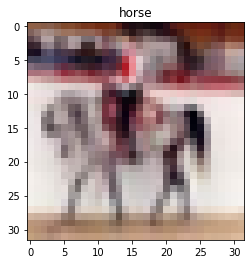

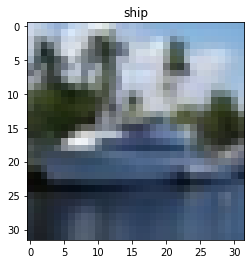

In [7]:
#데이터 가시화 
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

사용할 CNN 모델 불러오기

In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#CNN 모델 변경하려면 여기서 변경
#ImageNet으로 사전 훈련된 모델 불러오기, 분류층 포함 안 함
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                                classes=1000,
                                               weights='imagenet')

29097984/29084464 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

불러온 모델에서 데이터 셋의 클래스 수에 맞게 최종 분류층 교체 

In [10]:
#GAP 층
global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')
#분류 층
prediction_layer=keras.layers.Dense(num_classes, activation='softmax',name='predictions')

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

모델 아키텍처 살펴보기 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1024)             0         
 ing2D)                                                          
                                                                 
 predictions (Dense)         (None, 10)                10250     
                                                                 
Total params: 7,047,754
Trainable params: 6,964,106
Non-trainable params: 83,648
_________________________________________________________________


모델 컴파일

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


모델 훈련

In [13]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    batch_size=BATCH_SIZE)

Epoch 1/2
2813/2813 [==============================] - 632s 215ms/step - loss: 0.3487 - accuracy: 0.8826 - val_loss: 0.1939 - val_accuracy: 0.9380
Epoch 2/2
2813/2813 [==============================] - 594s 211ms/step - loss: 0.1686 - accuracy: 0.9442 - val_loss: 0.1837 - val_accuracy: 0.9356


학습 곡선 그리기

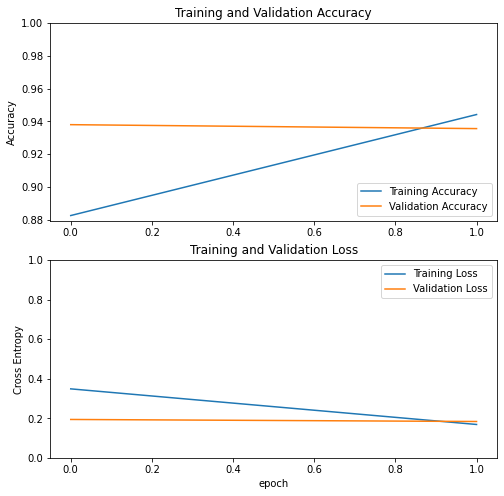

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Test Set으로 학습된 모델 테스트

In [15]:
loss_and_metrics = model.evaluate(test_batches, batch_size=64)
print("테스트 성능 : {}%".format(round(loss_and_metrics[1]*100,4)))

625/625 [==============================] - 39s 62ms/step - loss: 0.1956 - accuracy: 0.9347
테스트 성능 : 93.47%
